# Exercise - transfer learning

1. Use the CIFAR-10 data. Use a pre-model to extract features (i.e. "cut off" its head and then predict on the images to obtain new features). Train a neural network on these extracted features. Is it better than the model you trained last week on CIFAR-10?
2. Combine the base of the model you extracted features with and the new model you just trained. Combine them into one model and perform fine-tuning. Remember to use a low learning rate. How well does the combined model perform?
3. Perform more selective fine-tuning, i.e. only fine-tune *some* layers. Which works best - fine-tuning all layers or only some?
4. Try to understand what is happening in your model by visualizing some of the activations of your model. Further, try to visualize filters - both at the start of your model and further in your model.
5. (Bonus): Find the images your model misclassify (i.e. perform wrong predictions). For some of these, use class activation maps to investigate which parts of the image fools your network.

**Note**: You may want to use:
1. To see a list of pre-trained models you may use: https://www.tensorflow.org/api_docs/python/tf/keras/applications

**Note**: The pre-traned models you transfer from are trained on larger image sizes. This gives rise to some issues when working on CIFAR-10 (as the images are relatively small), as the architecture of the models you transfer from are not "built" for such small images. Nonetheless, I believe working with small images is still best as an exercise, as working with larger images is much more computationally expensive and hence take more time (which is not optimal in an exercise). Transfer learning still works even if the image sizes vary, but it can get too extreme if the discrepancy is large.

To get practice with "proper" transfer learning (on appropriate size images), take a look at the assignment and consider working with the dogs vs. cats challenge (see https://www.kaggle.com/c/dogs-vs-cats).

**See slides for more details!**

## Setup:

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


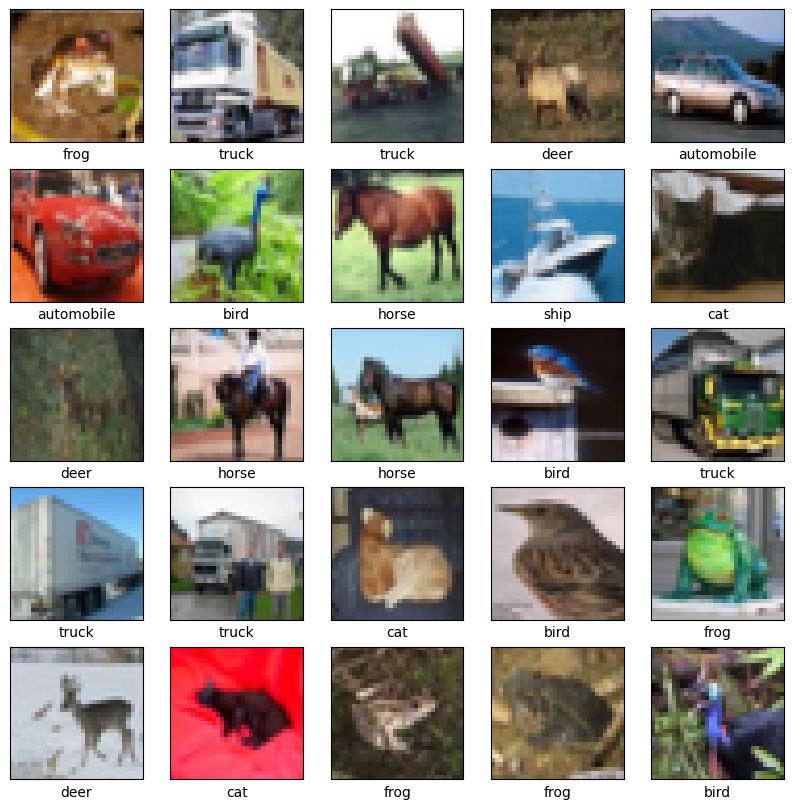

In [21]:
import tensorflow as tf
from matplotlib import pyplot as plt

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1) # to change from array of arrays format
print(train_images.shape, train_labels.shape, test_images.shape, test_labels.shape)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()

# Exercise 1

Use the CIFAR-10 data. Use a pre-model to extract features (i.e. "cut off" its head and then predict on the images to obtain new features). Train a neural network on these extracted features. Is it better than the model you trained last week on CIFAR-10?

Feature extraction: Here, you cut off the head of the CNN you transfer from. You then send all your images through this network and save the transformed features. You then proceed as normal on these new features (that are likely to be better than the raw images). Strenght: Very fast and does not require a lot of computational to use. Relatively easy to use.

**The CIFAR-10 data consist of 60.000 32*32 color images in 10 classes (above)**

**Using a Pre-Trained Model (MobileNetV2) for feature extraction:**
- Cut off head
- Freeze the weights 

**Then we extract the features:**
- Each image of CIFAR-10 is fed through the MobileNetV2 network. Notice that input-size of CIFAR-10 is 32x32 and MobileNetV2 can adapt this input - even if it expect inputs of size 224x224.
- Each image of CIFAR-10 is passed through the network - extracting features through multiple layers, kernels and poolings. Notice we cant see the architecture here. 

<br>

The code 2 * train_images - 1 and 2 * test_images - 1 indicates a rescaling step. This is likely done to match the preprocessing that was applied to the images MobileNetV2 was originally trained on. ImageNet-pretrained models often expect input images to be normalized in a certain way, which may not be the simple (0,1) range. This specific rescaling shifts the range from (0,1) to (-1, 1).

In [22]:
base_model = tf.keras.applications.MobileNetV2(
    #input_shape=(96, 96, 3), # refers to the shape we transfer from
    include_top=False, # cut off the head
    weights='imagenet', # pretrained on the ImageNet data
)
base_model.trainable = False # freeze the base model to not train it 
                             # not needed for pure feature extraction,
                             # but needed for the feature extraction 
                             # with multiple passes (as it is implemented here)

# Create new features
z_train = base_model.predict(2 * train_images - 1) # Note the rescaling
z_test = base_model.predict(2 * test_images - 1) # Note the rescaling

313/313 [==============================] - 7s 22ms/step


**We just extracted the features using the pre-trained model:**
- We end up with dimentions (1, 1, 1280) from the body of the pre-trained-model.
- The dimention is then our starting point using our own model below.
- We can just train the model as we normally would.
- The extracted features is a starting point - each input now has shape (1, 1, 1280).

In [23]:
model_pfe = tf.keras.models.Sequential([
    # flatten before fully connected part
    tf.keras.layers.Flatten(input_shape=(1, 1, 1280)), 
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
    ])

model_pfe.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )

model_pfe.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 64)                81984     
                                                                 
 dense_13 (Dense)            (None, 10)                650       
                                                                 
Total params: 82,634
Trainable params: 82,634
Non-trainable params: 0
_________________________________________________________________


In [24]:
history_pfe = model_pfe.fit(z_train, train_labels, 
                            validation_data=(z_test, test_labels), 
                            epochs=15, verbose=1)

Epoch 1/15
1563/1563 [==============================] - 3s 2ms/step - loss: 2.0061 - accuracy: 0.2723 - val_loss: 1.9522 - val_accuracy: 0.2788
Epoch 2/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.9232 - accuracy: 0.2969 - val_loss: 1.9207 - val_accuracy: 0.2928
Epoch 3/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8963 - accuracy: 0.3078 - val_loss: 1.9124 - val_accuracy: 0.2974
Epoch 4/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8775 - accuracy: 0.3126 - val_loss: 1.9025 - val_accuracy: 0.2995
Epoch 5/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8624 - accuracy: 0.3184 - val_loss: 1.8977 - val_accuracy: 0.3055
Epoch 6/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8498 - accuracy: 0.3230 - val_loss: 1.8959 - val_accuracy: 0.3048
Epoch 7/15
1563/1563 [==============================] - 3s 2ms/step - loss: 1.8377 - accuracy: 0.3274 - val_loss: 1.8983 - val_accuracy:

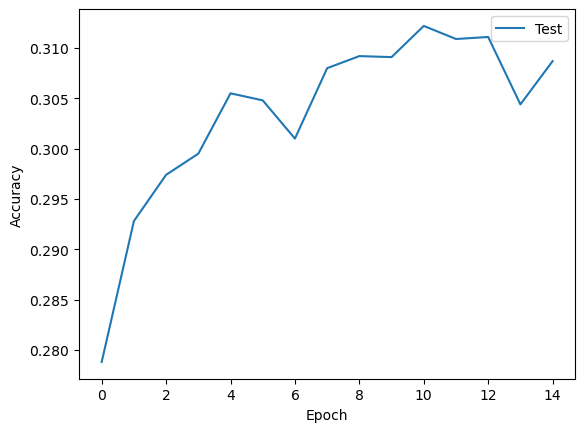

In [25]:
plt.plot(history_pfe.history['val_accuracy'], 
         label = 'Pure feature extraction')
plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.legend()

# Exercise 2

Combine the base of the model you extracted features with and the new model you just trained. Combine them into one model and perform fine-tuning. Remember to use a low learning rate. How well does the combined model perform?

**Combine feature extraction with fine-tuning:**
- Use the pre-trained model
- Use the images as input (CIFAR-10)
- Augment the images
- Now we dont freeze the body - we train it - and apply our own "head" (the classification part/flatten).

**This model is called "initialization with augmentation", where we train the whole model - we dont freeze nothing!**

In [26]:
# Define the data augmentation layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

# Define the complete model with data augmentation and the rest of the layers
model_weight_init = tf.keras.models.Sequential([
    data_augmentation, # Data augmentation layer
    tf.keras.applications.MobileNetV2(
        include_top=False,        # Cut off the head
        weights='imagenet',       # Pretrained on the ImageNet data
        input_shape=(32, 32, 3),  # Specify the input shape if required
    ),                            # The pre-trained part
    tf.keras.layers.Flatten(),    # Flatten before the fully connected part
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax'),
])

# Compile the model
model_weight_init.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # Lower learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [27]:
model_weight_init.build(train_images.shape)  
model_weight_init.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (50000, 32, 32, 3)        0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_7 (Flatten)         (50000, 1280)             0         
                                                                 
 dense_14 (Dense)            (50000, 64)               81984     
                                                                 
 dense_15 (Dense)            (50000, 10)               650       
                                                                 
Total params: 2,340,618
Trainable params: 2,306,506
Non-trainable params: 34,112
______________________________________

In [28]:
history_weight_init = model_weight_init.fit(2 * train_images - 1, train_labels,
                      validation_data=(2 * test_images - 1, test_labels), 
                      epochs=15, verbose=1)

Epoch 1/15
1563/1563 [==============================] - 175s 106ms/step - loss: 1.8191 - accuracy: 0.3500 - val_loss: 1.9687 - val_accuracy: 0.4062
Epoch 2/15
1563/1563 [==============================] - 157s 100ms/step - loss: 1.4246 - accuracy: 0.4950 - val_loss: 1.4944 - val_accuracy: 0.5042
Epoch 3/15
1563/1563 [==============================] - 149s 95ms/step - loss: 1.2486 - accuracy: 0.5590 - val_loss: 1.2537 - val_accuracy: 0.5607
Epoch 4/15
1563/1563 [==============================] - 161s 103ms/step - loss: 1.1325 - accuracy: 0.6035 - val_loss: 1.0856 - val_accuracy: 0.6303
Epoch 5/15
1563/1563 [==============================] - 164s 105ms/step - loss: 1.0423 - accuracy: 0.6383 - val_loss: 1.0349 - val_accuracy: 0.6424
Epoch 6/15
1563/1563 [==============================] - 160s 102ms/step - loss: 0.9732 - accuracy: 0.6661 - val_loss: 0.8566 - val_accuracy: 0.7079
Epoch 7/15
1563/1563 [==============================] - 160s 102ms/step - loss: 0.9178 - accuracy: 0.6852 - val_l

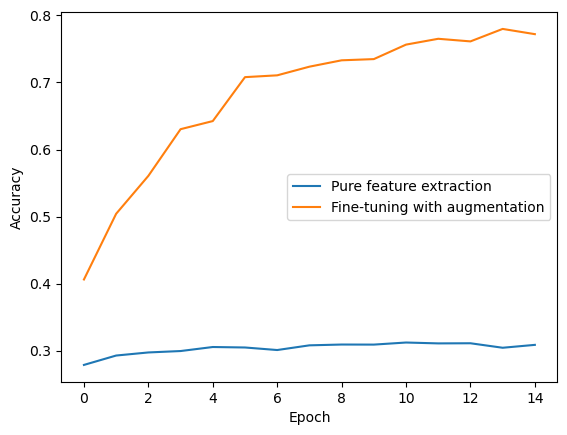

In [29]:
plt.plot(history_pfe.history['val_accuracy'], 
         label = 'Pure feature extraction')
plt.plot(history_weight_init.history['val_accuracy'],
         label = 'initialization with augmentation')
plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.legend()

# Exercise 3

Perform more selective fine-tuning, i.e. only fine-tune *some* layers. Which works best - fine-tuning all layers or only some?

**Same as before, but this time we freeze part of the model - and train the defined top of the body. In this case layers after number 500!**

In [44]:
head_ft = tf.keras.models.clone_model(model_pfe)
head_ft.set_weights(model_pfe.get_weights())

base_model_ft = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(32, 32, 3), # refers to the shape we transfer from...
    include_top=False,       # cut off the head
    weights='imagenet',      # pretrained on the ImageNet data
)
base_model_ft.training = False # to disable updating of means and 
                               # variances in batch norm layers
                               # This is in some cases very important, 
                               # but in this case it would still 
                               # work fine if we did not do it

for layer in base_model_ft.layers[:100]: # layers after number 100
    layer.trainable = False              #in base_model now trainable
    
model_ft = tf.keras.models.Sequential([
    data_augmentation, # can still use data augmentation now
    base_model_ft, # the pre-trained part
    head_ft, # the classifer we trained using feature extraction
])

model_ft.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001), # use a low learning rate
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
    )

In [45]:
model_ft.build(train_images.shape)  
model_ft.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 32, 32, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 sequential_11 (Sequential)  (None, 10)                82634     
                                                                 
Total params: 2,340,618
Trainable params: 1,944,074
Non-trainable params: 396,544
_________________________________________________________________


In [46]:
history_model_ft = model_ft.fit(2 * train_images - 1, train_labels,
                      validation_data=(2 * test_images - 1, test_labels), 
                      epochs=15, verbose=1)

Epoch 1/15
1563/1563 [==============================] - 100s 58ms/step - loss: 7.3503 - accuracy: 0.2222 - val_loss: 2.2778 - val_accuracy: 0.1679
Epoch 2/15
1563/1563 [==============================] - 91s 59ms/step - loss: 1.9492 - accuracy: 0.3174 - val_loss: 1.9536 - val_accuracy: 0.2769
Epoch 3/15
1563/1563 [==============================] - 94s 60ms/step - loss: 1.7480 - accuracy: 0.3755 - val_loss: 1.6167 - val_accuracy: 0.4333
Epoch 4/15
1563/1563 [==============================] - 91s 58ms/step - loss: 1.6222 - accuracy: 0.4177 - val_loss: 1.3911 - val_accuracy: 0.5031
Epoch 5/15
1563/1563 [==============================] - 91s 58ms/step - loss: 1.5341 - accuracy: 0.4537 - val_loss: 1.4072 - val_accuracy: 0.5202
Epoch 6/15
1563/1563 [==============================] - 90s 58ms/step - loss: 1.4873 - accuracy: 0.4748 - val_loss: 1.3656 - val_accuracy: 0.5218
Epoch 7/15
1563/1563 [==============================] - 90s 57ms/step - loss: 1.4366 - accuracy: 0.4940 - val_loss: 1.3347 

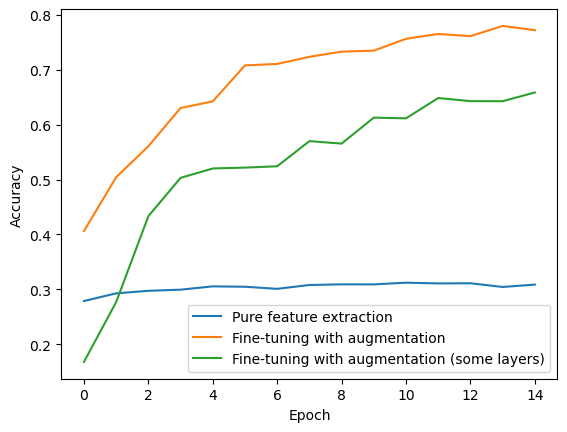

In [48]:
plt.plot(history_pfe.history['val_accuracy'], 
         label = 'Pure feature extraction')
plt.plot(history_weight_init.history['val_accuracy'],
         label = 'Fine-tuning with augmentation')
plt.plot(history_model_ft.history['val_accuracy'],
         label = 'Fine-tuning with augmentation (some layers)')
plt.xlabel('Epoch');plt.ylabel('Accuracy');plt.legend()

# Exercise 4

Try to understand what is happening in your model by visualizing some of the activations of your model. Further, try to visualize filters - both at the start of your model and further in your model.

# Exercise 5

(Bonus): Find the images your model misclassify (i.e. perform wrong predictions). For some of these, use class activation maps to investigate which parts of the image fools your network.